In [2]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

# Preprocessing:

In [3]:
# Initialize an empty list to store DataFrames
dataframes = []

# Iterate over all files matching the pattern
for file in glob.glob("../subject-*-pandasRecall.csv"):
    # Read the CSV file into a DataFrame
    temp_df = pd.read_csv(file)
    
    # Extract the subject number from the filename
    subject_number = os.path.basename(file).split('-')[1].split('.')[0]
    
    # Add a new column for the subject number
    temp_df['subject_number'] = subject_number
    
    # Append the DataFrame to the list
    dataframes.append(temp_df)

# Concatenate all DataFrames into a single DataFrame
all_data = pd.concat(dataframes, ignore_index=True)

# Remove rows with infinite reaction times
all_data = all_data[all_data['rt'] != np.inf]

all_data['subject_number'] = pd.to_numeric(all_data['subject_number'], errors='coerce')

In [4]:
# Read the CSV file into a DataFrame
subject_words_timebar = pd.read_csv('subject_words_timebar.csv')

In [5]:
# Select only the necessary columns from subject_words_timebar
subject_words_timebar_reduced = subject_words_timebar[['subject_number', 'question', 'answer', 'time_bar_visible']]

# Merge all_data and subject_words_timebar_reduced on subject_number, prompt (question), and answer
combined_data = pd.merge(all_data, subject_words_timebar_reduced, how='inner', left_on=['subject_number', 'prompt', 'answer'], right_on=['subject_number', 'question', 'answer'])

# Drop the 'question' column as it is redundant now
combined_data = combined_data.drop(columns=['question'])

# First calculate the results for each subject and show them in a boxplot:

In [6]:
# Group by 'subject_number' and 'time_bar_visible' and calculate additional statistics
evals = combined_data.groupby(['subject_number', 'time_bar_visible']).agg(
    accuracy=('correct', 'mean'),
    mean_rt=('rt', 'mean'),
    std_rt=('rt', 'std'),
    median_rt=('rt', 'median'),
    trial_count=('trial_num', 'count')
).reset_index()

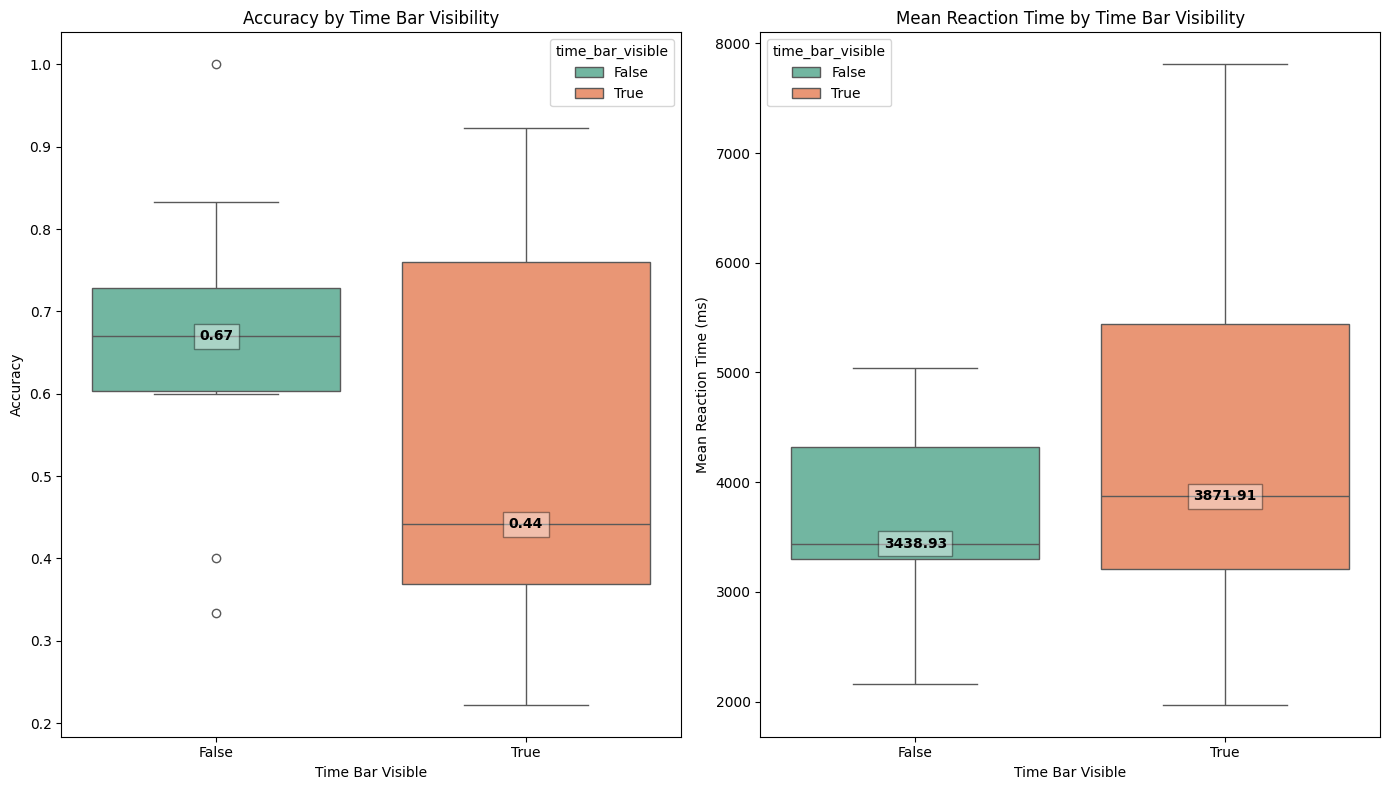

In [107]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Plot accuracy
sns.boxplot(ax=axes[0], x='time_bar_visible', y='accuracy', data=evals, palette='Set2', hue='time_bar_visible')
axes[0].set_title('Accuracy by Time Bar Visibility')
axes[0].set_xlabel('Time Bar Visible')
axes[0].set_ylabel('Accuracy')

# Calculate and add median values for accuracy
median_accuracy = evals.groupby('time_bar_visible')['accuracy'].median()
for i, median in enumerate(median_accuracy):
    axes[0].text(i, median, f'{median:.2f}', ha='center', va='center', color='black', fontweight='bold', bbox=dict(facecolor='white', alpha=0.4))

# Plot mean reaction time
sns.boxplot(ax=axes[1], x='time_bar_visible', y='mean_rt', data=evals, palette='Set2', hue='time_bar_visible')
axes[1].set_title('Mean Reaction Time by Time Bar Visibility')
axes[1].set_xlabel('Time Bar Visible')
axes[1].set_ylabel('Mean Reaction Time (ms)')

# Calculate and add median values for mean reaction time
median_rt = evals.groupby('time_bar_visible')['mean_rt'].median()
for i, median in enumerate(median_rt):
    axes[1].text(i, median, f'{median:.2f}', ha='center', va='center', color='black', fontweight='bold', bbox=dict(facecolor='white', alpha=0.4))

# Show the plots
plt.tight_layout()
plt.show()

# accuracy and reaction time over all trials:

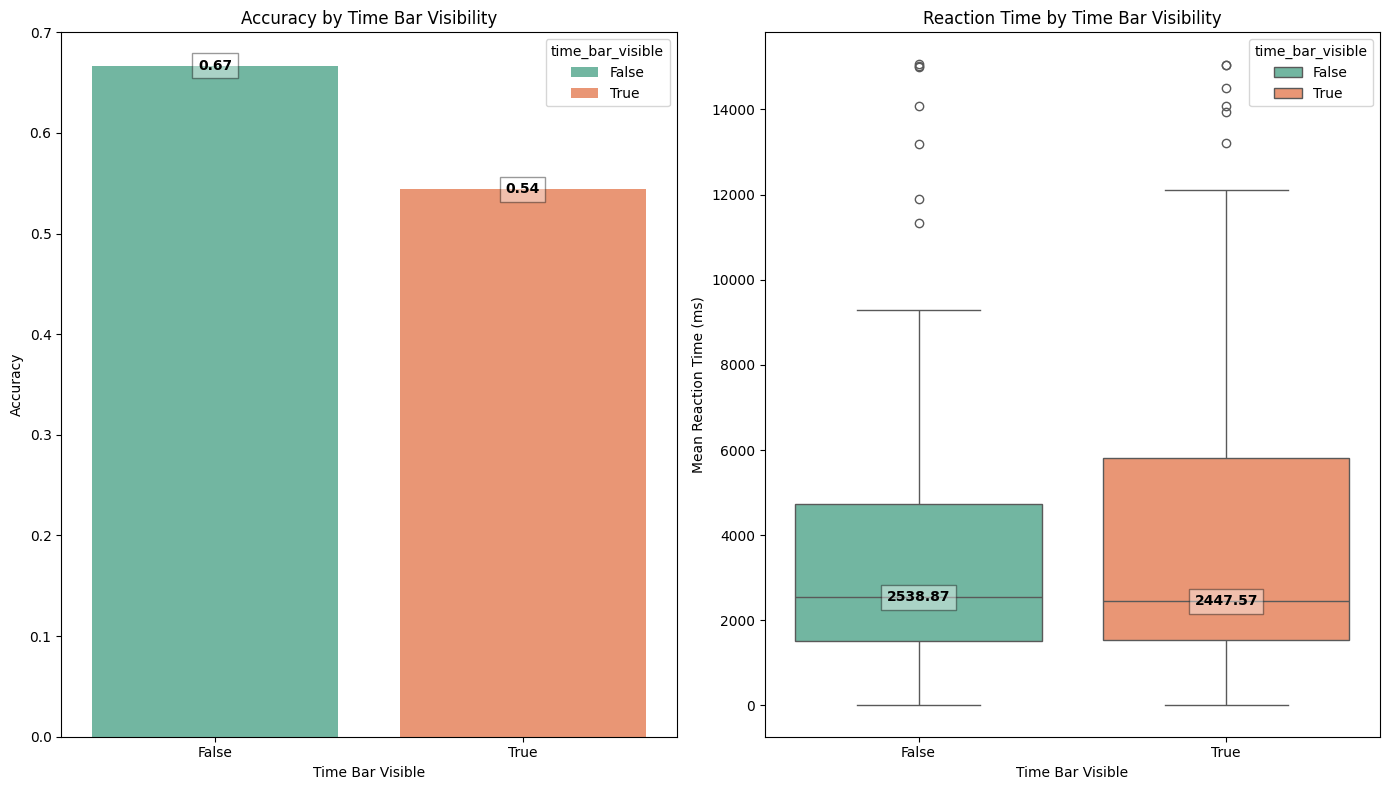

In [119]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Plot accuracy as a barplot
sns.barplot(ax=axes[0], x='time_bar_visible', y='correct', data=combined_data, palette='Set2', hue='time_bar_visible', errorbar=None)
axes[0].set_title('Accuracy by Time Bar Visibility')
axes[0].set_xlabel('Time Bar Visible')
axes[0].set_ylabel('Accuracy')

# Calculate and add median values for accuracy
median_accuracy = combined_data.groupby('time_bar_visible')['correct'].mean()
for i, median in enumerate(median_accuracy):
    axes[0].text(i, median, f'{median:.2f}', ha='center', va='center', color='black', fontweight='bold', bbox=dict(facecolor='white', alpha=0.4))

# Plot mean reaction time
sns.boxplot(ax=axes[1], x='time_bar_visible', y='rt', data=combined_data, palette='Set2', hue='time_bar_visible')
axes[1].set_title('Reaction Time by Time Bar Visibility')
axes[1].set_xlabel('Time Bar Visible')
axes[1].set_ylabel('Mean Reaction Time (ms)')

# Calculate and add median values for mean reaction time
median_rt = combined_data.groupby('time_bar_visible')['rt'].median()
for i, median in enumerate(median_rt):
    axes[1].text(i, median, f'{median:.2f}', ha='center', va='center', color='black', fontweight='bold', bbox=dict(facecolor='white', alpha=0.4))

# Show the plots
plt.tight_layout()
plt.show()

# t-test: first calculate metrics within subject:

In [9]:
from scipy.stats import ttest_ind

# Separate the data based on the time_bar_visible condition
data_time_bar_visible_true = evals[evals['time_bar_visible'] == True]
data_time_bar_visible_false = evals[evals['time_bar_visible'] == False]

# Perform t-test for accuracy
t_stat_accuracy, p_value_accuracy = ttest_ind(data_time_bar_visible_true['accuracy'], data_time_bar_visible_false['accuracy'])

# Perform t-test for mean reaction time
t_stat_mean_rt, p_value_mean_rt = ttest_ind(data_time_bar_visible_true['mean_rt'], data_time_bar_visible_false['mean_rt'])

print(f"Number of subjects with time bar visible: {len(data_time_bar_visible_true)}")
print(f"Number of subjects with time bar not visible: {len(data_time_bar_visible_false)}")

print(f"T-test for Accuracy: t-statistic = {t_stat_accuracy}, p-value = {p_value_accuracy}")
print(f"T-test for Mean Reaction Time: t-statistic = {t_stat_mean_rt}, p-value = {p_value_mean_rt}")

Number of subjects with time bar visible: 10
Number of subjects with time bar not visible: 10
T-test for Accuracy: t-statistic = -1.2250475960675822, p-value = 0.23634710591478125
T-test for Mean Reaction Time: t-statistic = 1.0595945659605428, p-value = 0.30334132983520795


# t-test over all trials:

In [10]:
# Separate the data based on the time_bar_visible condition
data_time_bar_visible_true = combined_data[combined_data['time_bar_visible'] == True]
data_time_bar_visible_false = combined_data[combined_data['time_bar_visible'] == False]

# Perform t-test for accuracy
t_stat_accuracy, p_value_accuracy = ttest_ind(data_time_bar_visible_true['correct'], data_time_bar_visible_false['correct'])

# Perform t-test for mean reaction time
t_stat_mean_rt, p_value_mean_rt = ttest_ind(data_time_bar_visible_true['rt'], data_time_bar_visible_false['rt'])

print(f"Number of trials with time bar visible: {len(data_time_bar_visible_true)}")
print(f"Number of trials with time bar not visible: {len(data_time_bar_visible_false)}")

print(f"T-test for Accuracy: t-statistic = {t_stat_accuracy}, p-value = {p_value_accuracy}")
print(f"T-test for Mean Reaction Time: t-statistic = {t_stat_mean_rt}, p-value = {p_value_mean_rt}")

Number of trials with time bar visible: 125
Number of trials with time bar not visible: 129
T-test for Accuracy: t-statistic = -2.008467630433854, p-value = 0.04566054796274885
T-test for Mean Reaction Time: t-statistic = 1.4801691039668559, p-value = 0.14007721623721472


# number of correct and incorrect answer for each condition. (number are first calculated within subject)

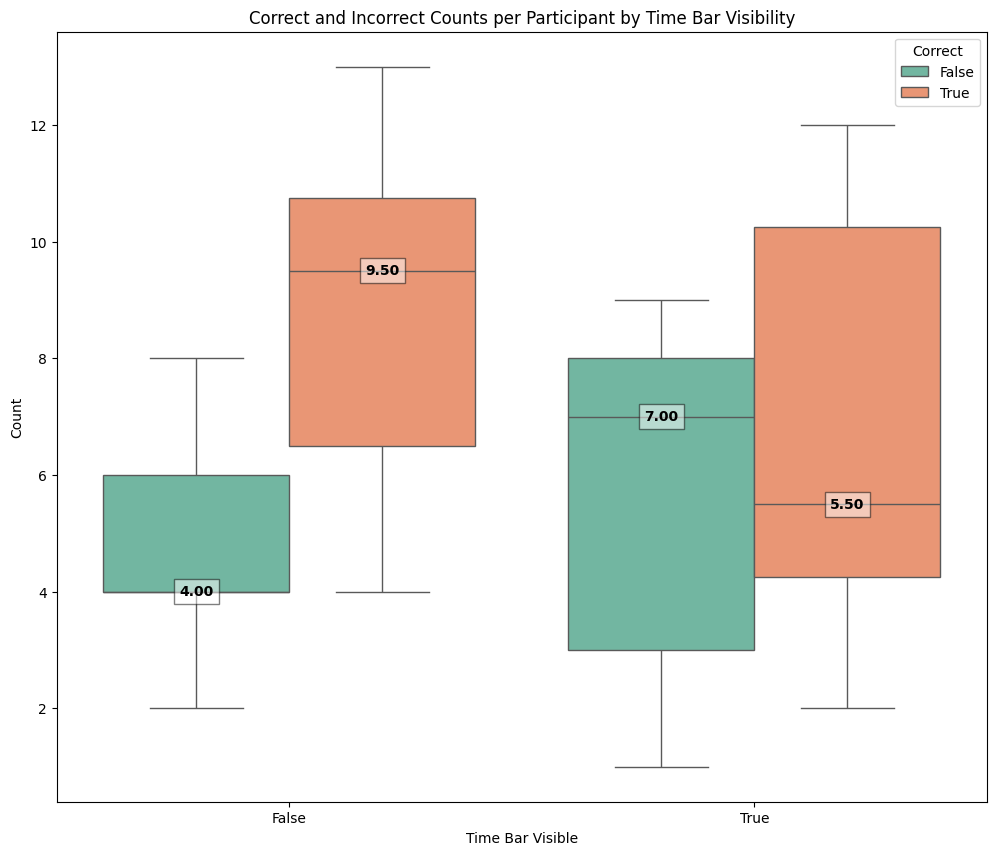

In [118]:
# Group by 'subject_number', 'time_bar_visible', and 'correct' and count the occurrences
correct_incorrect_count_per_participant = combined_data.groupby(['subject_number', 'time_bar_visible', 'correct']).size().reset_index(name='count')

# Create a boxplot for correct_incorrect_count_per_participant
plt.figure(figsize=(12, 10))
sns.boxplot(x='time_bar_visible', y='count', hue='correct', data=correct_incorrect_count_per_participant, palette='Set2')
plt.title('Correct and Incorrect Counts per Participant by Time Bar Visibility')
plt.xlabel('Time Bar Visible')
plt.ylabel('Count')
plt.legend(title='Correct')

# Calculate and add mean values for each group
mean_counts = correct_incorrect_count_per_participant.groupby(['time_bar_visible', 'correct'])['count'].median().reset_index()
for i, row in mean_counts.iterrows():
    x_coord = i // 2 + (i % 2) * 0.2  # Adjust x-coordinate calculation
    if i in [0, 2]:
        x_coord -= 0.2
    plt.text(x_coord, row['count'], f'{row["count"]:.2f}', ha='center', va='center', color='black', fontweight='bold', bbox=dict(facecolor='white', alpha=0.5))

plt.show()


# Overall correct and incorrect answer per condition

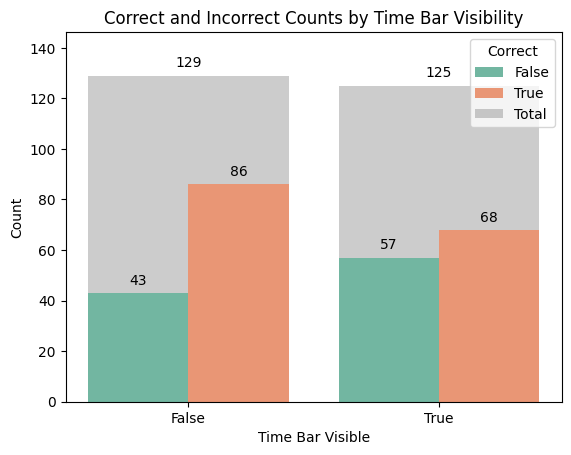

In [92]:
# Group by 'time_bar_visible' and 'correct' and count the occurrences
correct_incorrect_count = combined_data.groupby(['time_bar_visible', 'correct']).size().reset_index(name='count')

# Calculate the number of items for each condition
num_items_per_condition = combined_data.groupby(['time_bar_visible']).size().reset_index(name='num_items')

# Plot the original barplot
barplot = sns.barplot(x='time_bar_visible', y='count', hue='correct', data=correct_incorrect_count, palette='Set2')
plt.title('Correct and Incorrect Counts by Time Bar Visibility')
plt.xlabel('Time Bar Visible')
plt.ylabel('Count')
plt.legend(title='Correct')

# Add num_items_per_condition as an extra bar for each condition
for i, row in num_items_per_condition.iterrows():
    plt.bar(row['time_bar_visible'], row['num_items'], color='grey', alpha=0.4, label='Total' if i == 0 else "", zorder=0)

# Add numbers on top of each bar
for p in barplot.patches:
    if p.get_height() > 0:  # Only annotate bars with height greater than 0
        barplot.annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 9), 
                         textcoords='offset points')

# Add padding to the top of the graph
max_count = correct_incorrect_count['count'].max()
plt.ylim(0, max_count * 1.7)  # Extend the upper limit by 10%

# Update the legend to include 'Total Items' only once
handles, labels = barplot.get_legend_handles_labels()
if 'Total' not in labels:
    handles.append(plt.Rectangle((0, 0), 1, 1, color='grey', alpha=0.4))
    labels.append('Total')
barplot.legend(handles=handles, labels=labels, title='Correct')

plt.show()
